<a href="https://colab.research.google.com/github/ishagupta0506/Kaggle-Competiton-3/blob/main/TSS_Kaggle_Competition_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'tss24-competition-3:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F82103%2F8942240%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240626%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240626T174105Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2e0ea98b1706aa2305b11e4f0f1db6693367303619feab46992c6b906a54f479a5b1cab46163fd4479cbdf29497f76abb3af99dac130f32a88b8a782aae56e934cdb999e97041a2cb3bf6ad8f8e176f5cd19683f3960322333ddfd5a715ea9c30a4cbaf6dcc4a4fd4bab49735d2341e5c8abc34708cca05f66418c88fd830029f43b8d8b09dec4d3cd923f5523bdbf7cb1dab8820a462a12bf414767f9ea6893e704d287cb44ec97e7573c1400688f656e07956ee743786c8576600d53f936cb070835df8faa39ecb6b2b050b407cb86150e5ad28e7b0af2151f80b8f9672d3bb4d483cc8de54a9253350baf0c808b7bab4306fb57735ab761e61ad77629ba4f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 7141303 bytes downloaded
Downloaded and uncompressed: tss24-competition-3
Data source import complete.


## Overview

Machine learning (ML) is a field of artificial intelligence (AI) that focuses on developing algorithms that can learn from data. This notebook demonstrates the concepts of how to make a good ML model for data prediction.

**Data Loading and Preparation**: Load the dataset and prepare features and target variable.

**Exploratory Data Analysis (EDA)**: Exploring the dataset to understand its structure, distribution, and relationships between variables.

**Preprocess the data**: Based on the type of data you have, choose the possible preprocessing steps like :-
* Dropping null values
* Normalisation
* Encoding
* Oversampling

**Model Training**: Decide the model you want to use and train it.

**Model Evaluation**: Assess the performance of the trained model using evaluation metrics such as accuracy and confusion matrix.

**Model Tuning**: Try tuning the model by changing parameters of model for achieving better results.

**Prediction on Test Data**: Using the trained model to make predictions on unseen test data for submission.

By following these steps in sequence, ensure that the data is properly prepared and the model is trained and evaluated correctly before making predictions on new data.

### Importing Libraries

In [2]:
import pandas as pd # Data manipulation and reading
import numpy as np # linear algebra and mathematical operations
import matplotlib.pyplot as plt # library for plotting
import seaborn as sns # library for plotting
from sklearn.model_selection import train_test_split # library to split data
from sklearn.preprocessing import StandardScaler # Preprocessing by Normalisation
from xgboost import XGBClassifier # Importing the model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score # Importing Evaluation metrics

### Defining Data

In [3]:
train = pd.read_csv("/kaggle/input/tss24-competition-3/train.csv")
test = pd.read_csv("/kaggle/input/tss24-competition-3/test.csv")

In [4]:
train.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55,165,60,81.0,0.5,0.6,1,1,135,...,40,75,16.5,1,1.0,22,25,27,0,1
1,1,70,165,65,89.0,0.6,0.7,2,2,146,...,57,126,16.2,1,1.1,27,23,37,1,0
2,2,20,170,75,81.0,0.4,0.5,1,1,118,...,45,93,17.4,1,0.8,27,31,53,0,1
3,3,35,180,95,105.0,1.5,1.2,1,1,131,...,38,102,15.9,1,1.0,20,27,30,1,0
4,4,30,165,60,80.5,1.5,1.0,1,1,121,...,44,93,15.4,1,0.8,19,13,17,0,1


### Checking the data

In [5]:
train.shape

(159256, 24)

In [6]:
train.dtypes

id                       int64
age                      int64
height(cm)               int64
weight(kg)               int64
waist(cm)              float64
eyesight(left)         float64
eyesight(right)        float64
hearing(left)            int64
hearing(right)           int64
systolic                 int64
relaxation               int64
fasting blood sugar      int64
Cholesterol              int64
triglyceride             int64
HDL                      int64
LDL                      int64
hemoglobin             float64
Urine protein            int64
serum creatinine       float64
AST                      int64
ALT                      int64
Gtp                      int64
dental caries            int64
smoking                  int64
dtype: object

In [7]:
train.isna().sum()

id                     0
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64

### Splitting the data

In [8]:
X = train.drop(['id', 'smoking'], axis=1)
y = train['smoking']

### Visualising the data

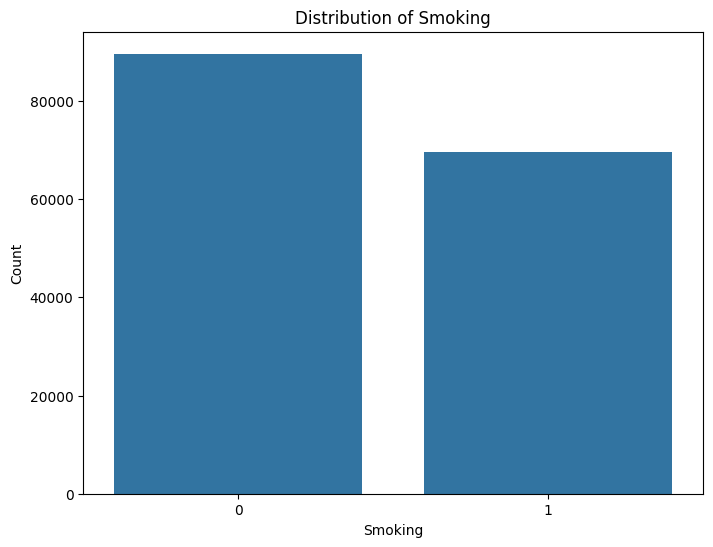

In [9]:
plt.figure(figsize=(8, 6))
sns.countplot(x=y)
plt.title('Distribution of Smoking')
plt.xlabel('Smoking')
plt.ylabel('Count')
plt.show()

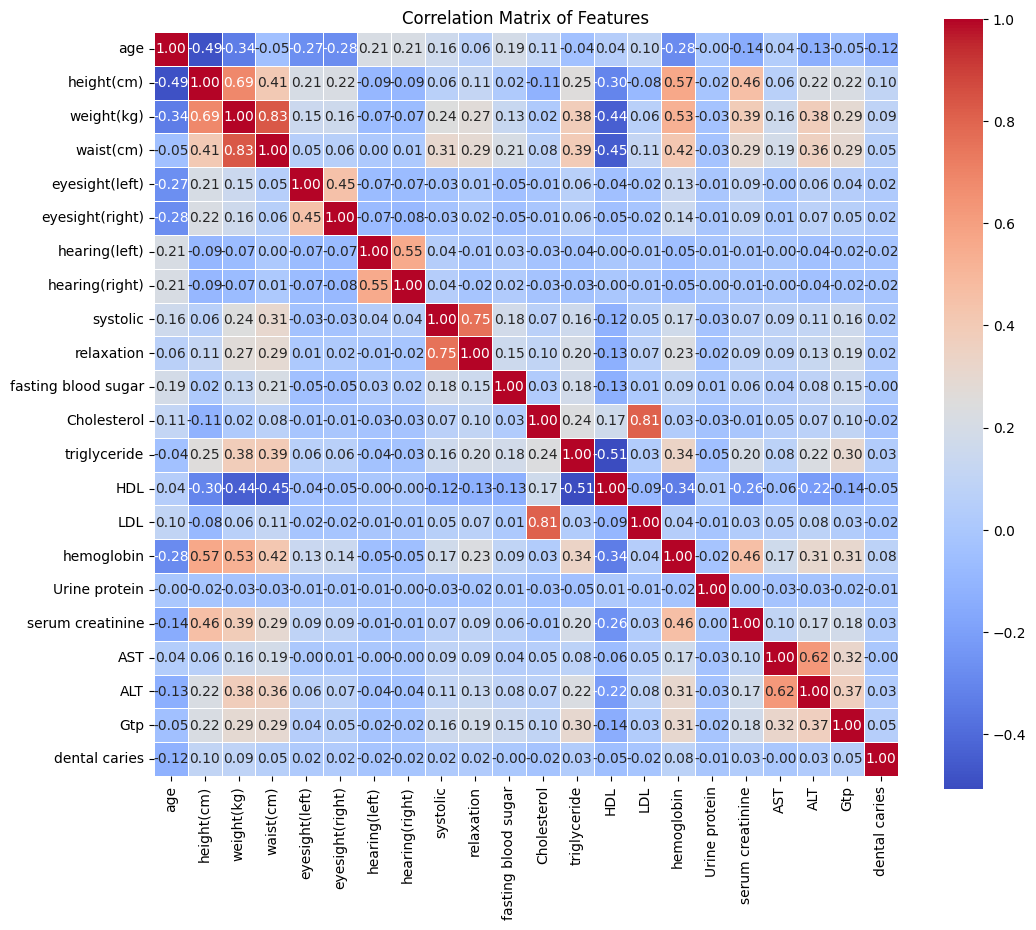

In [10]:
X.dropna(subset = X.select_dtypes('number').columns, inplace=True)
corr = X.select_dtypes('number').corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()

### Preprocessing the data

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

### Defining and training our model

In [13]:
model = XGBClassifier(objective='binary:logistic',  # Specify logistic regression for classification
                      n_estimators=100,  # Number of trees to grow
                      learning_rate=0.1,  # Learning rate
                      max_depth=5,  # Maximum depth of each tree
                      subsample=0.8,  # Subsample ratio for bagging
                      colsample_bytree=0.8,  # Feature subsample ratio
                      random_state=42)  # Set random state for reproducibility

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

### Evaluating our model

In [14]:
val_predictions = model.predict_proba(X_val_scaled)[:, 1]
auc = roc_auc_score(y_val, val_predictions)
print(f'Model AUC on Validation Set: {auc:.4f}')

Model AUC on Validation Set: 0.5057


### Plotting the feature importance given by our model

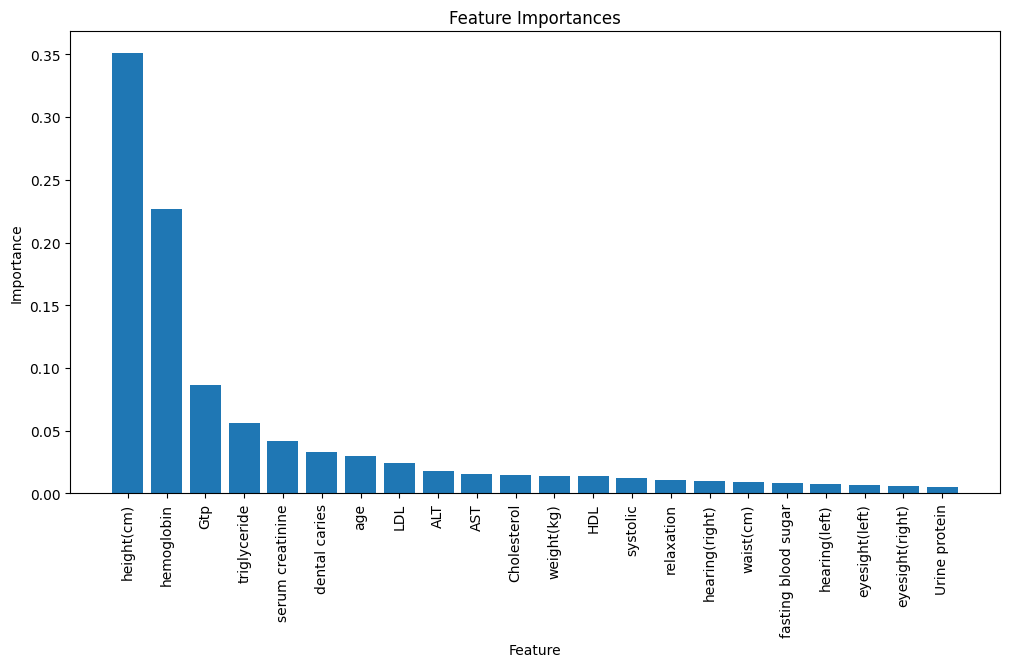

In [15]:
importances = model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()


### ROC Curve

ROC (Receiver Operating Characteristic) Curve
The ROC curve is a graph that shows how well a binary classification model is performing. It plots the True Positive Rate (how many actual positives are correctly identified) against the False Positive Rate (how many actual negatives are incorrectly identified as positives) at different threshold settings. Essentially, it helps you see how good the model is at distinguishing between the positive and negative classes.

AUC (Area Under the Curve)
AUC stands for Area Under the ROC Curve. It provides a single number that summarizes the performance of the model. The AUC value ranges from 0 to 1:

1 means perfect prediction.
0.5 means the model is no better than random guessing.
Higher AUC values indicate better model performance.


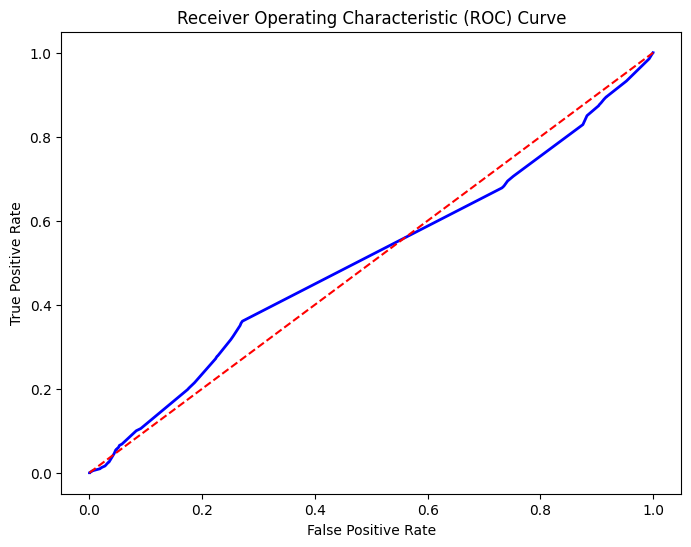

In [16]:
fpr, tpr, _ = roc_curve(y_val, val_predictions)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### Preparing the test data for predictions

In [17]:
X_test = test.drop('id', axis = 1)
X_test_scaled = scaler.transform(X_test)

### Making Predictions and Submission file

In [18]:
test_predictions = model.predict_proba(X_test_scaled)[:, 1]

In [20]:
submission = pd.DataFrame({'id': test['id'], 'smoking': test_predictions})
submission.to_csv('submission1.csv', index=False)
print("Submission file created successfully.")

Submission file created successfully.
